In [ ]:
!pip install -U transformers accelerate datasets evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 21.8 MB/s eta 0:00:00


In [ ]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


El desafío a realizarse consiste en realizar un estudios exploratorio de 3 modelos en la tarea de clasificación de emociones (https://github.com/fmplaza/EmoEvent/tree/master/splits). Este dataset contiene 8409 tweets anotados con una de las siguientes categorías: anger, sadness, joy, disgust, fear, surprise, offensive, other. Además, los tweets están relacionados a eventos particulares encontrados en Twitter.

Los requerimientos son los siguientes:
* Deben explorar 3 modelos, pueden entrenar los propios (por ejemplo, una Red Neuronal Recurrente o una Sequence-to-Sequence), hacer fine-tuning (por ejemplo de Bert o T5) o usar un modelo ya listo (por ejemplo, GPT-4o). (9 puntos)
* Deben reportar los resultados por cada emoción (categoría) y también realizar un análisis por evento, matriz de confusión entre otras cosas que consideren pertinente. (5 puntos)
* Debe publicar lo desarrollado en un notebook disponible en GitHub. La entrega debe incluir solo el link al repositorio. (3 puntos)
* El notebook debe estar detallado en cada paso. (3 puntos)

# Mount on drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NLP-PhawA

/content/drive/MyDrive/NLP-PhawA


## Load dataset

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

# lang = "es"
lang = "en"

train_df = pd.read_csv(f"splits/{lang}/train.tsv", sep="\t")
dev_df   = pd.read_csv(f"splits/{lang}/dev.tsv", sep="\t")
test_df  = pd.read_csv(f"splits/{lang}/test.tsv", sep="\t")

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(dev_df),
    "test": Dataset.from_pandas(test_df)
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 5112
    })
    validation: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 744
    })
    test: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 1447
    })
})


In [ ]:
labels = dataset["train"].unique("emotion")
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

def encode_labels(example):
    example["label"] = label2id[example["emotion"]]
    return example

dataset = dataset.map(encode_labels)

Map:   0%|          | 0/5112 [00:00<?, ? examples/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Map:   0%|          | 0/1447 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels),
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")
    }

def train_model(model_name, dataset, label2id, id2label):
    print(f"\n🚀 Entrenando {model_name}...\n")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(batch):
        return tokenizer(batch["tweet"], padding="max_length", truncation=True, max_length=128)

    tokenized = dataset.map(tokenize, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        logging_dir=f"./logs_{model_name}",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate(tokenized["test"])
    print(f"Resultados {model_name}: {eval_results}\n")

    return trainer, eval_results


In [ ]:
import os
# Disable for BERT model
os.environ["WANDB_DISABLED"] = "true"

# Recurrent Neural Network

## Cargar datos

In [ ]:
import pandas as pd

lang = "en"  # cambia a "es" si quieres español
train_df = pd.read_csv(f"splits/{lang}/train.tsv", sep="\t")
dev_df   = pd.read_csv(f"splits/{lang}/dev.tsv", sep="\t")
test_df  = pd.read_csv(f"splits/{lang}/test.tsv", sep="\t")

X_train, y_train = train_df["tweet"], train_df["emotion"]
X_dev, y_dev     = dev_df["tweet"], dev_df["emotion"]
X_test, y_test   = test_df["tweet"], test_df["emotion"]

## Codificar etiquetas


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_dev_enc   = label_encoder.transform(y_dev)
y_test_enc  = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)

In [ ]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_dev_cat   = to_categorical(y_dev_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000   # tamaño vocabulario
max_len = 50        # longitud máxima de tweet

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_dev_seq   = pad_sequences(tokenizer.texts_to_sequences(X_dev), maxlen=max_len)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)


In [ ]:
## Definir modelo RNN (Embedding + LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.3))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================================
# 5) Entrenar
# ============================================
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_dev_seq, y_dev_cat),
    batch_size=64,
    epochs=20,
    verbose=1
)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.4009 - loss: 1.6675 - val_accuracy: 0.4530 - val_loss: 1.4328
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.4677 - loss: 1.4201 - val_accuracy: 0.4973 - val_loss: 1.3312
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.5157 - loss: 1.2324 - val_accuracy: 0.5081 - val_loss: 1.3015
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.6520 - loss: 0.9699 - val_accuracy: 0.5121 - val_loss: 1.3749
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.7384 - loss: 0.7423 - val_accuracy: 0.4973 - val_loss: 1.5588
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.8064 - loss: 0.5624 - val_accuracy: 0.5094 - val_loss: 1.7000
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.8524 - loss: 0.4386 - val_accuracy: 0.4919 - val_loss: 1.7697
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.8902 - loss: 0.3446 - val_accu

In [ ]:
# Evaluar modelo en test
loss, acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)

# Predicciones
y_pred_probs = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calcular F1
f1_macro = f1_score(y_true, y_pred, average="macro")

# Imprimir resultados
print(f"RNN (LSTM) resultados - Test Accuracy: {acc:.4f}, F1 (macro): {f1_macro:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RNN (LSTM) resultados - Test Accuracy: 0.4333, F1 (macro): 0.2629


# BERT

In [ ]:
models = [
    "bert-base-uncased"
]

results = {}

for model_name in models:
    trainer, eval_results = train_model(model_name, dataset, label2id, id2label)
    results[model_name] = eval_results


🚀 Entrenando bert-base-uncased...



Map:   0%|          | 0/5112 [00:00<?, ? examples/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Map:   0%|          | 0/1447 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2026917644.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.084414,{'accuracy': 0.5779569892473119},{'f1': 0.5243371287973652}
2,1.107400,0.983193,{'accuracy': 0.6317204301075269},{'f1': 0.6074189900491993}
3,1.107400,1.056886,{'accuracy': 0.6290322580645161},{'f1': 0.6125692336683649}
4,0.697300,1.312611,{'accuracy': 0.614247311827957},{'f1': 0.5932046425177133}
5,0.354400,1.463613,{'accuracy': 0.6075268817204301},{'f1': 0.5984355303684805}
6,0.354400,1.713370,{'accuracy': 0.5940860215053764},{'f1': 0.5916097415114283}
7,0.191600,1.926842,{'accuracy': 0.5806451612903226},{'f1': 0.5796274080769572}
8,0.096100,2.068557,{'accuracy': 0.592741935483871},{'f1': 0.5860117198161554}
9,0.096100,2.196277,{'accuracy': 0.5940860215053764},{'f1': 0.5882480000742999}
10,0.051700,2.246324,{'accuracy': 0.5873655913978495},{'f1': 0.5828873252924389}


Trainer is attempting to log a value of "{'accuracy': 0.5779569892473119}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.5243371287973652}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6317204301075269}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6074189900491993}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6290322580645161}" of type <class 'dict'> fo

Trainer is attempting to log a value of "{'accuracy': 0.598479612992398}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.575873690280684}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.



📊 Resultados bert-base-uncased: {'eval_loss': 1.047061562538147, 'eval_accuracy': {'accuracy': 0.598479612992398}, 'eval_f1': {'f1': 0.575873690280684}, 'eval_runtime': 10.4362, 'eval_samples_per_second': 138.653, 'eval_steps_per_second': 8.72, 'epoch': 10.0}



# Ready to use models

In [ ]:
from transformers import pipeline
import evaluate
import numpy as np
from tqdm import tqdm

# Cargar modelo zero-shot
classifier = pipeline("zero-shot-classification",
                      model="joeddav/xlm-roberta-large-xnli")

# Extraer labels
labels = dataset["train"].unique("emotion")

# Métricas
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# Función para predecir
def zero_shot_predict(texts, labels):
    preds = []
    for t in tqdm(texts, desc="Zero-shot predicting"):
        result = classifier(t, candidate_labels=labels)
        preds.append(result["labels"][0])  # label con mayor score
    return preds

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
# Mapear labels a ids
true_ids = [label2id[l] for l in true_labels]
pred_ids = [label2id[l] for l in pred_labels]

# Calcular métricas ahora sí
acc = accuracy.compute(references=true_ids, predictions=pred_ids)
f1_macro = f1.compute(references=true_ids, predictions=pred_ids, average="macro")

print("🔹 Zero-Shot Accuracy:", acc)
print("🔹 Zero-Shot F1 (macro):", f1_macro)

🔹 Zero-Shot Accuracy: {'accuracy': 0.1824464409122322}
🔹 Zero-Shot F1 (macro): {'f1': 0.2215837673033401}


# Metrics


## Table comparing results

In [ ]:
import pandas as pd

results = {
    "bert-base-uncased": {"accuracy": 0.5985, "f1_macro": 0.5759},
    "RNN (LSTM)": {"accuracy": 0.4333, "f1_macro": 0.2629},
    "Zero-Shot XLM-R": {"accuracy": 0.1824, "f1_macro": 0.2216}
}

df_results = pd.DataFrame(results).T

df_results

,accuracy,f1_macro
bert-base-uncased,0.5985,0.5759
RNN (LSTM),0.4333,0.2629
Zero-Shot XLM-R,0.1824,0.2216


## Loading metrics again

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Función de normalización de etiquetas
def ensure_label_ids(y_true, y_pred, labels):
    label2id = {lab: i for i, lab in enumerate(labels)}
    id2label = {i: lab for lab, i in label2id.items()}

    def to_id_list(y):
        if len(y)==0:
            return []
        if isinstance(y[0], (int, np.integer)):
            return list(map(int, y))
        return [label2id[s] for s in y]

    y_true_ids = to_id_list(y_true)
    y_pred_ids = to_id_list(y_pred)
    return y_true_ids, y_pred_ids, id2label, label2id

# Función principal de evaluación por modelo
def evaluate_and_report(y_true, y_pred, labels, model_name="model", show_confusion=True, normalize_confusion=True, save_csv_prefix=None):
    y_true_ids, y_pred_ids, id2label, label2id = ensure_label_ids(y_true, y_pred, labels)

    # métricas globales
    acc = accuracy_score(y_true_ids, y_pred_ids)
    f1_macro = f1_score(y_true_ids, y_pred_ids, average="macro")
    f1_weighted = f1_score(y_true_ids, y_pred_ids, average="weighted")
    precision_micro = precision_score(y_true_ids, y_pred_ids, average="micro")
    recall_micro = recall_score(y_true_ids, y_pred_ids, average="micro")

    print(f"\n=== Resultados - {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 (macro): {f1_macro:.4f}")
    print(f"F1 (weighted): {f1_weighted:.4f}")
    print(f"Precision (micro): {precision_micro:.4f}  Recall (micro): {recall_micro:.4f}\n")

    # reporte por clase
    print("---- Classification Report (por clase) ----")
    print(classification_report(y_true_ids, y_pred_ids, target_names=labels, digits=4))

    # matriz de confusion
    if show_confusion:
        cm = confusion_matrix(y_true_ids, y_pred_ids, labels=range(len(labels)))
        if normalize_confusion:
            with np.errstate(all='ignore'):
                cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                cm_to_plot = np.nan_to_num(cm_norm)
            title = f"Confusion matrix (normalized) - {model_name}"
            annot_fmt = ".2f"
        else:
            cm_to_plot = cm
            title = f"Confusion matrix (counts) - {model_name}"
            annot_fmt = "d"

        plt.figure(figsize=(10,8))
        sns.heatmap(cm_to_plot, xticklabels=labels, yticklabels=labels, annot=True, fmt=annot_fmt, cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(title)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.show()

    if save_csv_prefix is not None:
        df_out = pd.DataFrame({
            "y_true": [id2label[i] for i in y_true_ids],
            "y_pred": [id2label[i] for i in y_pred_ids]
        })
        csv_path = f"{save_csv_prefix}_{model_name.replace(' ','_')}_preds.csv"
        df_out.to_csv(csv_path, index=False)
        print(f"Predicciones guardadas en: {csv_path}")

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro
    }


In [ ]:
def per_event_analysis(df_with_event, y_true_col="emotion", y_pred_col="y_pred", event_col="event", labels=None, min_examples=5):
    rows = []
    for ev, g in df_with_event.groupby(event_col):
        if len(g) < min_examples:
            continue
        true = list(g[y_true_col])
        pred = list(g[y_pred_col])
        # convertir si labels entregadas
        if labels is not None:
            true_ids = [labels.index(t) for t in true]
            pred_ids = [labels.index(p) for p in pred]
        else:
            true_ids = true
            pred_ids = pred
        acc = accuracy_score(true_ids, pred_ids)
        f1m = f1_score(true_ids, pred_ids, average="macro")
        rows.append({"event": ev, "n": len(g), "accuracy": acc, "f1_macro": f1m})
    df_ev = pd.DataFrame(rows).sort_values("n", ascending=False)
    return df_ev

In [ ]:
from transformers import AutoTokenizer

# Cargar el mismo tokenizer del modelo usado en fine-tuning
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenizar dataset completo
def tokenize_function(examples):
    return tokenizer(examples["tweet"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Predecir con el trainer
predictions = trainer.predict(tokenized_dataset["test"])

# Extraer etiquetas y predicciones
bert_y_true = predictions.label_ids
bert_y_pred = predictions.predictions.argmax(-1)


Map:   0%|          | 0/5112 [00:00<?, ? examples/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

Map:   0%|          | 0/1447 [00:00<?, ? examples/s]

In [ ]:
# Evaluación RNN (LSTM)
loss, acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)

# Predicciones
y_pred_probs = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calcular F1
f1_macro = f1_score(y_true, y_pred, average="macro")

print(f"\n📊 RNN (LSTM) resultados - Test Accuracy: {acc:.4f}, F1 (macro): {f1_macro:.4f}")

# Guardar para comparación con evaluate_and_report
rnn_y_true = y_true
rnn_y_pred = y_pred


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step

📊 RNN (LSTM) resultados - Test Accuracy: 0.4333, F1 (macro): 0.2629


In [ ]:
# Guardar para comparación con evaluate_and_report
zs_y_true = true_ids
zs_y_pred = pred_ids


## BERT evaluation


=== Resultados - BERT (fine-tuned) ===
Accuracy: 0.5985
F1 (macro): 0.3832
F1 (weighted): 0.5759
Precision (micro): 0.5985  Recall (micro): 0.5985

---- Classification Report (por clase) ----
              precision    recall  f1-score   support

      others     0.6127    0.6931    0.6504       655
     disgust     0.3902    0.4238    0.4063       151
         joy     0.6530    0.7079    0.6793       404
       anger     0.3333    0.1026    0.1569        78
     sadness     0.6800    0.6145    0.6456        83
    surprise     0.6667    0.0435    0.0816        46
        fear     0.5000    0.0333    0.0625        30

    accuracy                         0.5985      1447
   macro avg     0.5480    0.3741    0.3832      1447
weighted avg     0.5889    0.5985    0.5759      1447



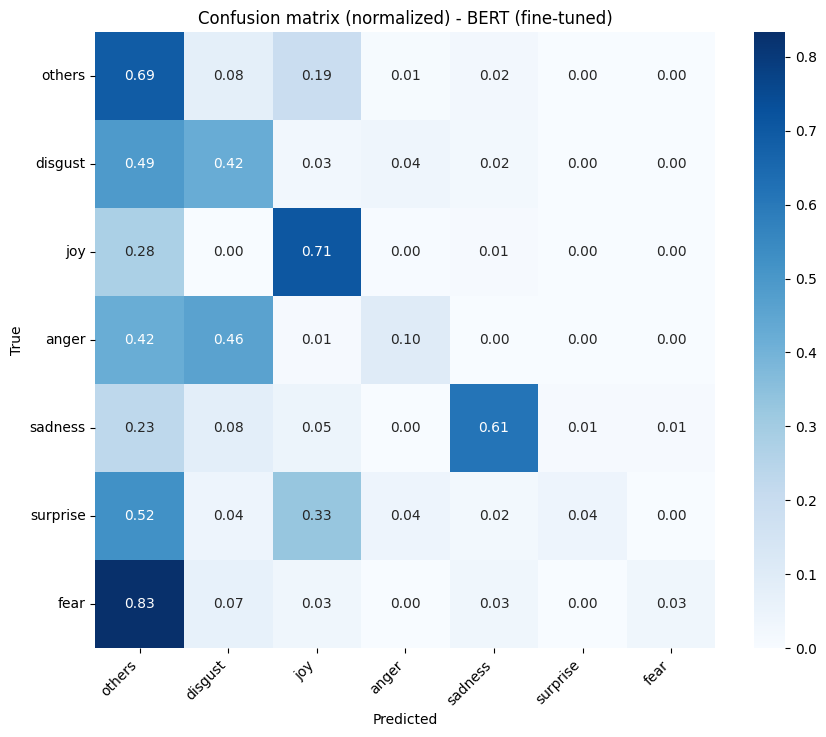

Predicciones guardadas en: results_BERT_(fine-tuned)_preds.csv


In [ ]:
# labels_list: todas las emociones
labels_list = dataset["train"].unique("emotion")

# Lista de labels (orden consistente con label2id)
labels_list = list(label2id.keys())

res_bert = evaluate_and_report(bert_y_true, bert_y_pred, labels_list, model_name="BERT (fine-tuned)", save_csv_prefix="results")

## RNN Evaluation


=== Resultados - RNN (LSTM) ===
Accuracy: 0.4333
F1 (macro): 0.2629
F1 (weighted): 0.4314
Precision (micro): 0.4333  Recall (micro): 0.4333

---- Classification Report (por clase) ----
              precision    recall  f1-score   support

      others     0.1277    0.0769    0.0960        78
     disgust     0.2890    0.3311    0.3086       151
         joy     0.0400    0.0333    0.0364        30
       anger     0.5232    0.5025    0.5126       404
     sadness     0.4993    0.5221    0.5104       655
    surprise     0.3519    0.2289    0.2774        83
        fear     0.0800    0.1304    0.0992        46

    accuracy                         0.4333      1447
   macro avg     0.2730    0.2608    0.2629      1447
weighted avg     0.4327    0.4333    0.4314      1447



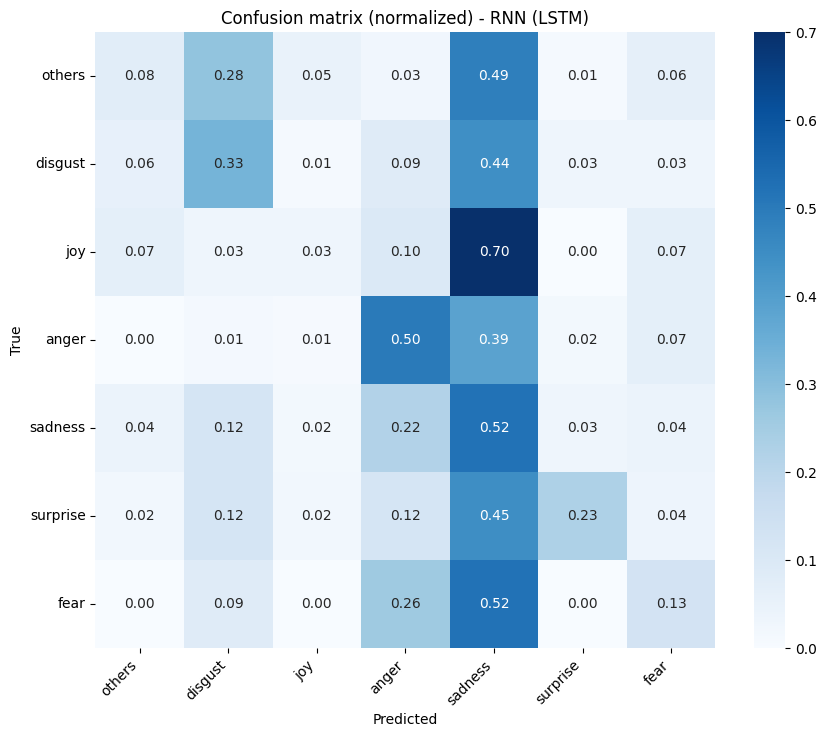

Predicciones guardadas en: results_RNN_(LSTM)_preds.csv


In [ ]:
res_rnn  = evaluate_and_report(rnn_y_true, rnn_y_pred, labels_list, model_name="RNN (LSTM)", save_csv_prefix="results")

## XLM-R Evaluation


=== Resultados - Zero-Shot XLM-R ===
Accuracy: 0.1824
F1 (macro): 0.2216
F1 (weighted): 0.2223
Precision (micro): 0.1824  Recall (micro): 0.1824

---- Classification Report (por clase) ----
              precision    recall  f1-score   support

      others     0.5052    0.0748    0.1303       655
     disgust     0.3673    0.1192    0.1800       151
         joy     0.6271    0.2748    0.3821       404
       anger     0.1613    0.0641    0.0917        78
     sadness     0.5345    0.3735    0.4397        83
    surprise     0.0427    0.9348    0.0816        46
        fear     0.2593    0.2333    0.2456        30

    accuracy                         0.1824      1447
   macro avg     0.3568    0.2964    0.2216      1447
weighted avg     0.4882    0.1824    0.2223      1447



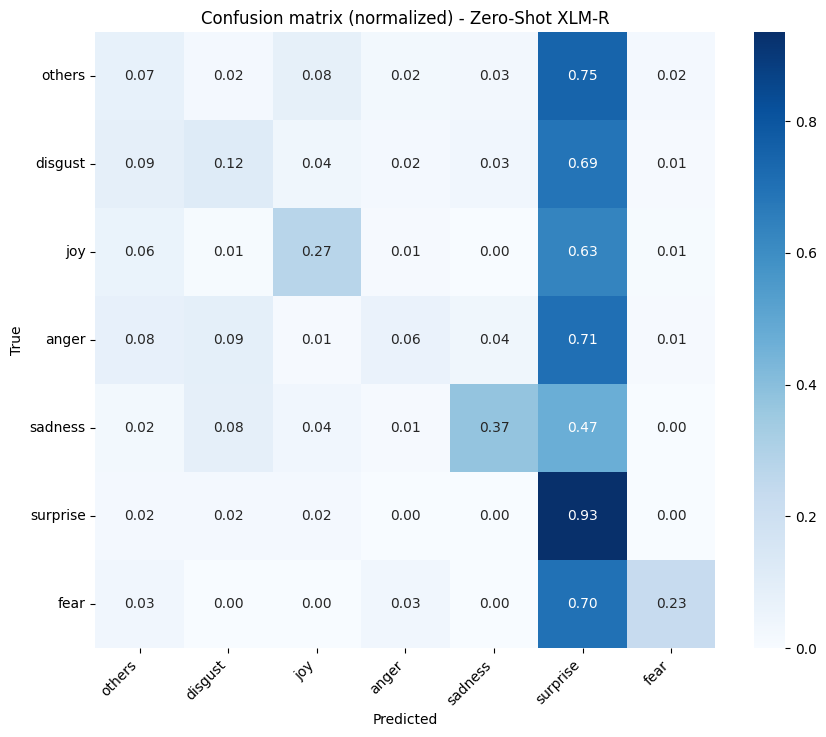

Predicciones guardadas en: results_Zero-Shot_XLM-R_preds.csv


In [ ]:
res_zs   = evaluate_and_report(zs_y_true, zs_y_pred, labels_list, model_name="Zero-Shot XLM-R", save_csv_prefix="results")